In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.sparse import csr_matrix
from scipy.stats import mannwhitneyu

# *NOTES
Methylation data has been pre-processed and standardized (Sartor et al., 2011)

# 1. Hierarchical clustering of methylation levels in HPV 

In [15]:
# Load DNA methylation data as a pandas DataFrame
methylation_data = pd.read_csv('Data/HPV_loci.csv', index_col=0)
deltas = methylation_data.pop('delta')
methylation_data_infection = methylation_data.drop(['GB','CHR','MAPINFO'], axis=1)
cpg_ids = methylation_data_infection.pop('CpG_ID')

# Saving to csv
methylation_data_infection.to_csv('Data/methylation_data_hpv.csv')
methylation_data_infection

,HPV_neg,HPV_pos
0,0.040,0.034
1,0.080,0.807
2,0.045,0.040
3,0.036,0.033
4,0.010,0.013
...,...,...
18851,0.019,0.072
18852,0.591,0.912
18853,0.009,0.013
18854,0.057,0.036


/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


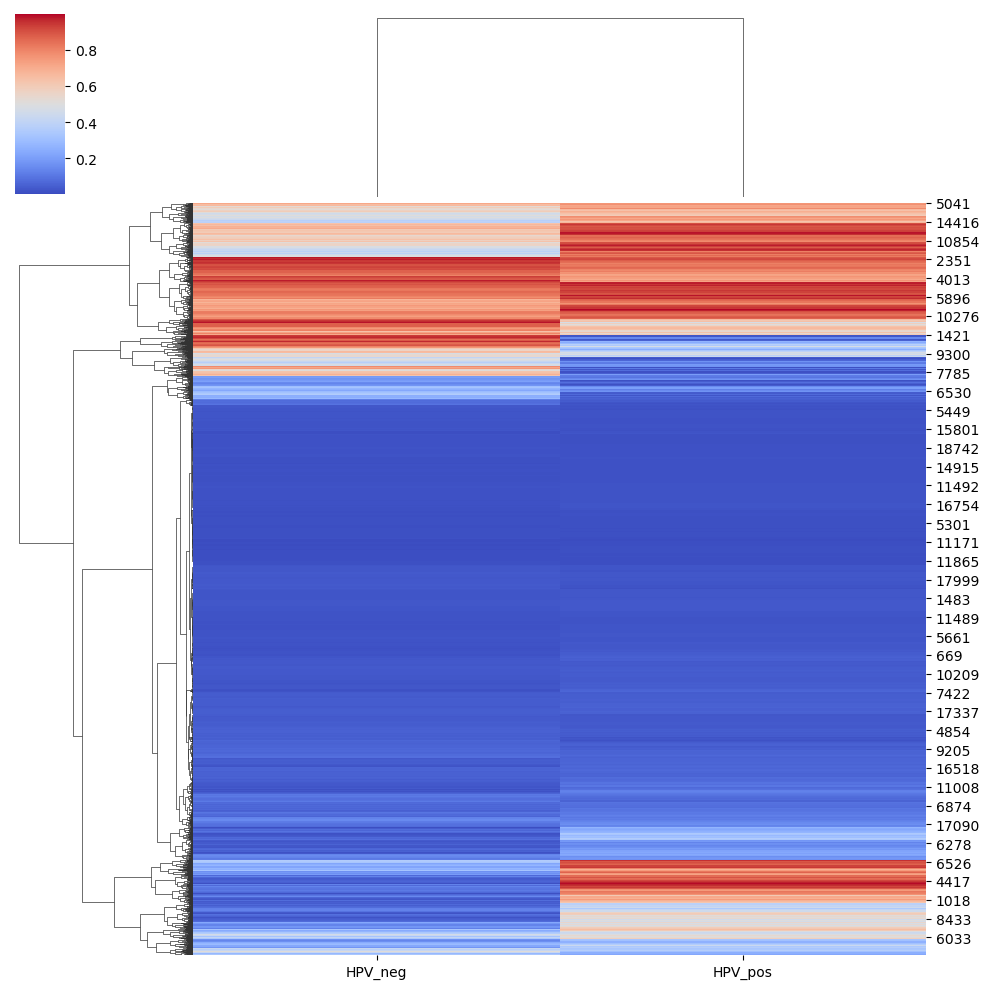

In [3]:
# Generate a clustermap 
sns.clustermap(methylation_data_infection, cmap='coolwarm')

# Display the heatmap
plt.show()

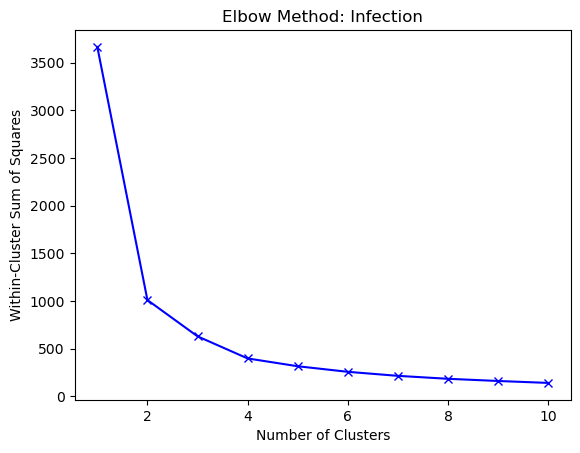

In [4]:
# Choosing the optimal number of clusters using k-means and calculating within-cluster sum of squares for each number 
# of clusters
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(methylation_data_infection)
    inertias.append(kmeans.inertia_)

# Plot the number of clusters against the within-cluster sum of squares
plt.plot(range(1, 11), inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method: Infection')
plt.show()

In [5]:
# Silhouette coefficient using optimal number of clusters
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100)
kmeans.fit(methylation_data_infection)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

silhouette_avg = silhouette_score(methylation_data_infection, labels)
print("The average silhouette coefficient is :", silhouette_avg)

The average silhouette coefficient is : 0.7204681560264555


/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


The average silhouette coefficient is : 0.659522926829098


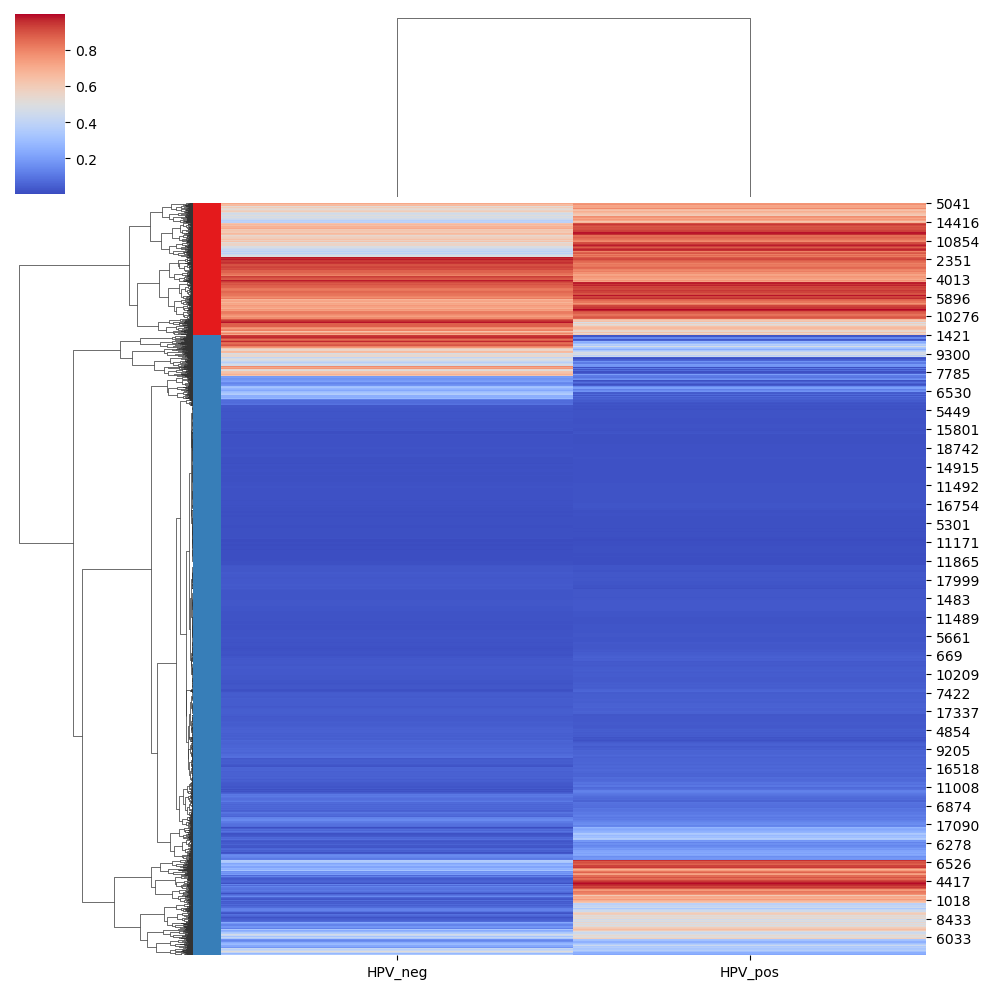

In [16]:
# Clustering by methylation level
# Calculating linkage matrix
linkages = linkage(methylation_data_infection, method='average') # Computing linkage matrix using average method

k = 2 # Number of clusters
clusters = fcluster(linkages, k, criterion='maxclust') # Assigns observations to at most k clusters
colors = sns.color_palette("Set1", n_colors=k)
row_colors = [colors[label - 1] for label in clusters] # So red (cluster 1) is hyper, blue (cluster 2) is hypo

sns.clustermap(methylation_data_infection, row_colors=row_colors, cmap='coolwarm') 

silhouette_avg = silhouette_score(methylation_data_infection, clusters)
print("The average silhouette coefficient is :", silhouette_avg)

In [7]:
# Extracting CpG_IDs for each methylation level cluster
cpg_ids = np.array(cpg_ids)
infection_clusters = np.array(clusters)
hyper = []
hypo = []

for i, cluster in enumerate(infection_clusters):
    if cluster == 1:
        hyper.append(cpg_ids[i])
    else:
        hypo.append(cpg_ids[i])
        
# Saving to csv files 
infection_cpgs_high = pd.DataFrame(hyper, columns=['CpG_ID'])
infection_cpgs_high.to_csv('Data/hpv_cpgs_high.csv')
infection_cpgs_low = pd.DataFrame(hypo, columns=['CpG_ID'])
infection_cpgs_low.to_csv('Data/hpv_cpgs_low.csv')

# 2. Violin plot depicting mean methylation levels

Text(0.5, 0, 'Infection')

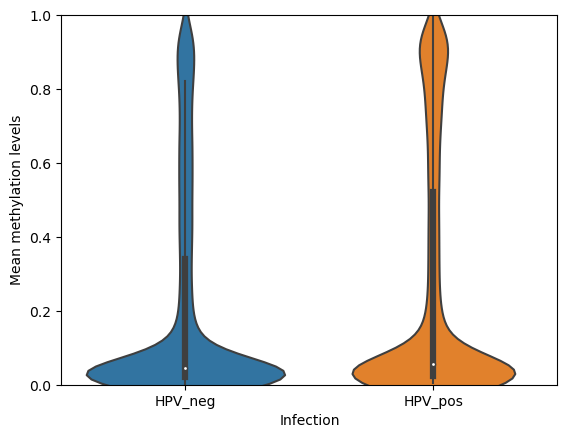

In [8]:
ax = sns.violinplot(data=methylation_data_infection, kde=True)
ax.set_ylim(0, 1)
plt.ylabel('Mean methylation levels')
plt.xlabel('Infection')

# 3. Methylation levels of CpG clusters

Goal: Trying to characterize the two identified CpG clusters. Are they high vs low methylation level groups? Are they large vs small delta methylation level groups post infection/treatment?

In [9]:
## Complete infection dataframe
# Change in methylation levels after infection
methylation_data_infection['delta'] = deltas

# Mean methylation levels
methylation_data_infection['Mean β-value'] = methylation_data_infection[['HPV_neg','HPV_pos']].mean(axis=1)

# CpG cluster associated with each CpG site
methylation_data_infection['CpG_cluster'] = infection_clusters
cluster_dict = {1: 'high', 2: 'low'}
methylation_data_infection['CpG_cluster'] = methylation_data_infection['CpG_cluster'].map(cluster_dict)
methylation_data_infection

,HPV_neg,HPV_pos,delta,Mean β-value,CpG_cluster
0,0.040,0.034,-0.006,0.0370,low
1,0.080,0.807,0.727,0.4435,low
2,0.045,0.040,-0.005,0.0425,low
3,0.036,0.033,-0.003,0.0345,low
4,0.010,0.013,0.003,0.0115,low
...,...,...,...,...,...
18851,0.019,0.072,0.053,0.0455,low
18852,0.591,0.912,0.321,0.7515,high
18853,0.009,0.013,0.004,0.0110,low
18854,0.057,0.036,-0.021,0.0465,low


In [10]:
# Separating into two dataframes each for DMP cluster
methylation_data_infection_high = methylation_data_infection[methylation_data_infection['CpG_cluster'] == 'high']
methylation_data_infection_low = methylation_data_infection[methylation_data_infection['CpG_cluster'] == 'low']

# Saving to csv
methylation_data_infection_high.to_csv('Data/methylation_data_hpv_high.csv')
methylation_data_infection_low.to_csv('Data/methylation_data_hpv_low.csv')

Text(0.5, 0, 'HPV')

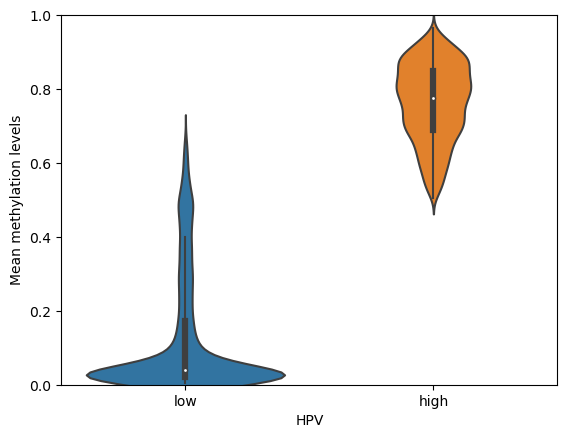

In [11]:
# Violin plot for each of the 2 CpG clusters using the mean β-value
ax = sns.violinplot(data=methylation_data_infection, x='CpG_cluster', y='Mean β-value') 
ax.set_ylim(0, 1)
plt.ylabel('Mean methylation levels')
plt.xlabel('HPV')

In [12]:
# Mann-Whitney U test
# Separate the data into two groups
low = methylation_data_infection[methylation_data_infection['CpG_cluster'] == 'low']['Mean β-value']
high = methylation_data_infection[methylation_data_infection['CpG_cluster'] == 'high']['Mean β-value']

statistic, p_value = mannwhitneyu(low, high)
print('Mann-Whitney U statistic:', statistic)
print('p-value:', p_value)

Mann-Whitney U statistic: 126861.0
p-value: 0.0


Text(0.5, 0, 'HPV')

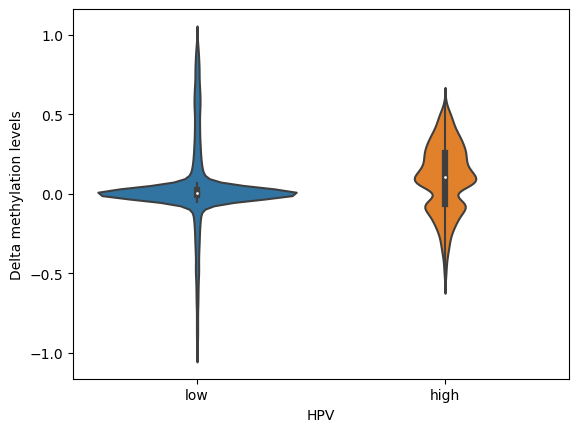

In [14]:
# Violin plot for each of the 2 CpG clusters using the Δβ-value
ax = sns.violinplot(data=methylation_data_infection, x='CpG_cluster', y='delta') 
plt.ylabel('Delta methylation levels')
plt.xlabel('HPV')

So clusters identified can broadly be categorized as high vs low methylation levels likely.